In [1]:
# ! pip install yfinance
# ! pip install scikit-learn
# ! pip install requests beautifulsoup4 pandas
# ! pip install lxml
# ! pip install seaborn



In [2]:
import requests
import pandas as pd
import re
from html import unescape
from io import StringIO

def fetch_fund_history(code, per=20):
    """从天天基金网抓取指定基金的历史净值数据，并合并到一个 DataFrame 中。"""
    page = 1
    all_dfs = []
    total_pages = None

    while True:
        url = f"https://fundf10.eastmoney.com/F10DataApi.aspx?type=lsjz&code={code}&page={page}&per={per}"
        response = requests.get(url, timeout=10)
        response.encoding = 'utf-8'

        # 提取 content 字段中的 HTML 表格
        match = re.search(r'content:"(.*?)",records', response.text)
        if not match:
            break
        html_str = unescape(match.group(1))
        # 通过 pandas 读取 HTML 表格
        df_list = pd.read_html(StringIO(html_str))
        if df_list:
            all_dfs.append(df_list[0])

        # 获取总页数
        if total_pages is None:
            pages_match = re.search(r'pages:(\d+)', response.text)
            if pages_match:
                total_pages = int(pages_match.group(1))
            else:
                break

        # 如果已经抓取完全部页数，则跳出循环
        if page >= total_pages:
            break
        page += 1

    if not all_dfs:
        raise ValueError("未能抓取到任何历史净值数据，请检查基金代码或网络设置。")
    return pd.concat(all_dfs, ignore_index=True)

# 抓取基金历史净值
fund_code = '007844'  # 目标基金代码
print("正在抓取基金历史数据，请稍候...")
raw_df = fetch_fund_history(fund_code)
print(f"已抓取 {len(raw_df)} 条记录。")

# 保存原始数据（可选）
raw_df.to_csv('/workspace/input/' + f'{fund_code}_history_raw.csv', index=False, encoding='utf-8-sig')
print(f"原始数据已保存至 {fund_code}_history_raw.csv")


正在抓取基金历史数据，请稍候...
已抓取 1368 条记录。
原始数据已保存至 007844_history_raw.csv


In [3]:
import pandas as pd

def clean_data(df):
    """对原始数据进行清洗，转换列名，并去除无用数据列"""
    
    # 检查数据是否加载正确
    if df.empty:
        raise ValueError("数据加载失败，表格为空。")
    
    # 将中文列名转换为英文
    df.columns = ['date', 'unit_nav', 'cum_nav', 'daily_rate', 'purchase', 'redeem', 'dividend']
    
    # 查看原始数据的前几行，确认数据格式
    print("原始数据前几行：")
    print(df.head())

    # 去除最后两列，因为其值相同
    if 'purchase' in df.columns and 'redeem' in df.columns:
        df = df.drop(columns=['purchase', 'redeem'])
    
    # 删除“单位净值”和“累计净值”其中一列，因为它们的值是相同的
    if 'cum_nav' in df.columns:
        df = df.drop(columns=['cum_nav'])

    # 进行日期转换，并检查是否存在转换失败的日期
    df['date'] = pd.to_datetime(df['date'], errors='coerce')  # 错误数据会变成 NaT
    print(f"转换日期后，NaT 数据数量：{df['date'].isna().sum()}")

    # 将“日增长率”列转化为小数形式，并检查是否有非数字字符
    df['daily_rate'] = df['daily_rate'].str.strip('%')
    df['daily_rate'] = pd.to_numeric(df['daily_rate'], errors='coerce')
    print(f"转换日增长率后，NaN 数据数量：{df['daily_rate'].isna().sum()}")

    # 将“单位净值”列转换为数值型，处理错误值
    df['unit_nav'] = pd.to_numeric(df['unit_nav'], errors='coerce')
    print(f"转换单位净值后，NaN 数据数量：{df['unit_nav'].isna().sum()}")

    # 计算收益率和涨跌方向
    df['return'] = df['unit_nav'].pct_change()
    df['direction'] = (df['return'] > 0).astype(int)  # 涨为1，跌为0
    
    # 按日期排序
    df = df.sort_values('date').reset_index(drop=True)
    
    # 去除 NaN 和空值，只删除含有 NaN 的行，而不是整个数据集
    df = df.dropna(subset=['unit_nav', 'daily_rate'])

    # 检查清洗后的数据是否为空
    if df.empty:
        raise ValueError("数据清洗后为空，请检查是否有有效数据。")
    
    return df


# 读取数据（假设文件已经上传）
file_path = '/workspace/input/007844_history_raw.csv'  # 更新为正确的路径
df = pd.read_csv(file_path)

# 清洗数据
cleaned_df = clean_data(df)

# 保存清洗后的数据
cleaned_file_path = '/workspace/input/007844_history_cleaned.csv'
cleaned_df.to_csv(cleaned_file_path, index=False, encoding='utf-8-sig')

print(f"数据清洗完成，已保存至：{cleaned_file_path}")


原始数据前几行：
         date  unit_nav  cum_nav daily_rate purchase redeem  dividend
0  2025-09-01    0.7252   0.7252      0.06%     暂停申购   暂停赎回       NaN
1  2025-08-29    0.7248   0.7248      0.10%   限制大额申购   开放赎回       NaN
2  2025-08-28    0.7241   0.7241      0.96%   限制大额申购   开放赎回       NaN
3  2025-08-27    0.7172   0.7172      1.31%   限制大额申购   开放赎回       NaN
4  2025-08-26    0.7079   0.7079     -0.34%   限制大额申购   开放赎回       NaN
转换日期后，NaT 数据数量：0
转换日增长率后，NaN 数据数量：2
转换单位净值后，NaN 数据数量：0
数据清洗完成，已保存至：/workspace/input/007844_history_cleaned.csv


In [4]:

# # 读取数据（假设文件已经上传）
# file_path = '/workspace/input/007844_history_raw.csv'  # 更新为正确的路径
# df = pd.read_csv(file_path)

# # 清洗数据
# cleaned_df = clean_data(df)

# # 保存清洗后的数据
# cleaned_file_path = '/workspace/input/007844_history_cleaned.csv'
# cleaned_df.to_csv(cleaned_file_path, index=False, encoding='utf-8-sig')

# print(f"数据清洗完成，已保存至：{cleaned_file_path}")

In [5]:
# 第一步：载入清洗后的数据，并做基础特征工程（适配小样本）

import pandas as pd
import numpy as np

# 读取清洗后的数据
file_path = '/workspace/input/007844_history_cleaned.csv'
df = pd.read_csv(file_path, parse_dates=['date'])

# 按时间排序（确保时序正确）
df = df.sort_values('date').reset_index(drop=True)

# 打印原始数据行数
print(f"原始数据行数：{len(df)}")

# 创建技术指标（适配较小数据量）
df['sma_3'] = df['unit_nav'].rolling(window=3, min_periods=1).mean()
df['sma_5'] = df['unit_nav'].rolling(window=5, min_periods=1).mean()
df['sma_7'] = df['unit_nav'].rolling(window=7, min_periods=1).mean()
df['volatility_3'] = df['unit_nav'].rolling(window=3, min_periods=1).std()

# 计算涨跌方向（如果未包含 direction，可以手动补）
if 'direction' not in df.columns:
    df['return'] = df['unit_nav'].pct_change()
    df['direction'] = (df['return'] > 0).astype(int)

# 去除最前面计算不出标准差的那几行（只对波动率为空的行做处理）
df = df.dropna(subset=['volatility_3']).reset_index(drop=True)

# 再次打印保留的数据行数
print(f"保留的数据行数：{len(df)}")

# 查看结果
df.head()


原始数据行数：1366
保留的数据行数：1365


,date,unit_nav,daily_rate,dividend,return,direction,sma_3,sma_5,sma_7,volatility_3
0,2020-01-17,0.3879,-1.52,NaN,0.003103,1,0.390900,0.390900,0.390900,0.004243
1,2020-01-20,0.3867,-0.31,NaN,0.033957,1,0.389500,0.389500,0.389500,0.003857
2,2020-01-21,0.3740,-3.28,NaN,0.018519,1,0.382867,0.385625,0.385625,0.007702
3,2020-01-22,0.3672,-1.82,NaN,0.013525,1,0.375967,0.381940,0.381940,0.009898
4,2020-02-03,0.3320,-8.36,NaN,-0.010432,0,0.357733,0.369560,0.373617,0.022544


🎯 分类报告:
              precision    recall  f1-score   support

           0       0.54      0.72      0.62       140
           1       0.54      0.35      0.42       133

    accuracy                           0.54       273
   macro avg       0.54      0.53      0.52       273
weighted avg       0.54      0.54      0.52       273

📊 混淆矩阵:


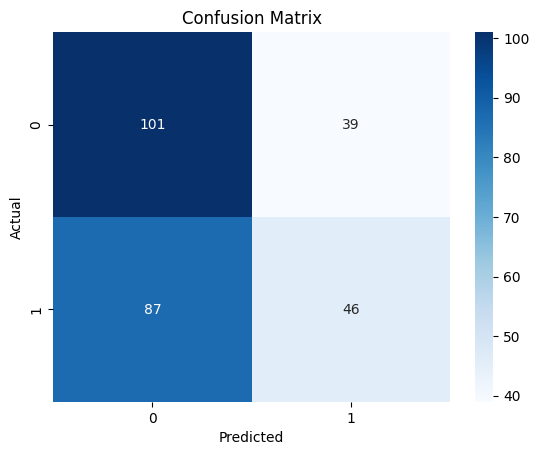

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 确认特征列
features = ['sma_3', 'sma_5', 'sma_7', 'volatility_3']
X = df[features]
y = df['direction']

# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分训练集和测试集（不打乱时间顺序）
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=False
)

# 初始化并训练随机森林模型
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 模型预测
y_pred = clf.predict(X_test)

# 输出评估指标
print("🎯 分类报告:")
print(classification_report(y_test, y_pred))
print("📊 混淆矩阵:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [7]:
# 回填预测结果到原始 dataframe（注意对齐）
df_eval = df.iloc[-len(y_test):].copy()  # 对应测试集部分
df_eval['predicted_direction'] = y_pred

# 根据预测方向生成操作信号
df_eval['signal'] = df_eval['predicted_direction'].map({1: 'buy', 0: 'sell'})

# 保存结果到本地 CSV
output_path = '/workspace/input/007844_with_signals.csv'
df_eval.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"✅ 策略信号已生成并保存至：{output_path}")
df_eval[['date', 'unit_nav', 'predicted_direction', 'signal']].head(10)


✅ 策略信号已生成并保存至：/workspace/input/007844_with_signals.csv


,date,unit_nav,predicted_direction,signal
1092,2024-07-19,0.7939,1,buy
1093,2024-07-22,0.7909,1,buy
1094,2024-07-23,0.7788,0,sell
1095,2024-07-24,0.7743,0,sell
1096,2024-07-25,0.7832,0,sell
1097,2024-07-26,0.7864,0,sell
1098,2024-07-29,0.7776,0,sell
1099,2024-07-30,0.7877,0,sell
1100,2024-07-31,0.7934,0,sell
1101,2024-08-01,0.7707,1,buy


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# ✅ 使用你实际生成过的特征列
features = ['sma_3', 'sma_5', 'sma_7', 'volatility_3']

# ✅ 打印每一列缺失值数量，方便调试
print("各特征列缺失值统计：")
print(df[features].isna().sum())

# ✅ 丢掉包含 NaN 的行（只考虑特征和标签列）
df_features = df.dropna(subset=features + ['direction']).copy()

# ✅ 再次确认剩余行数
print(f"可用于训练的数据行数：{len(df_features)}")
if df_features.empty:
    raise ValueError("训练数据为空，请检查特征列或缺失处理逻辑。")

# ✅ 特征与标签提取
X_all = df_features[features]
y_all = df_features['direction']

# ✅ 标准化
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

# ✅ 模型训练
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_all_scaled, y_all)

# ✅ 使用最新一行数据进行未来预测
latest_row = df_features.iloc[[-1]]
X_future = latest_row[features]
X_future_scaled = scaler.transform(X_future)
future_pred = clf.predict(X_future_scaled)[0]
future_signal = 'buy' if future_pred == 1 else 'sell'

print(f"\n📅 最新数据日期：{latest_row['date'].values[0]}")
print(f"📈 模型预测未来信号：{future_signal.upper()}（预测方向：{future_pred}）")



各特征列缺失值统计：
sma_3           0
sma_5           0
sma_7           0
volatility_3    0
dtype: int64
可用于训练的数据行数：1365

📅 最新数据日期：2025-09-01T00:00:00.000000000
📈 模型预测未来信号：SELL（预测方向：0）
